<a href="https://colab.research.google.com/github/ProfEddie/HypCLIP/blob/perceiver/lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from model.modules.dct import dct
from lavis.datasets.builders import load_dataset
from utils.data_utils import  get_loaders
from lavis.models import load_model_and_preprocess
import torch
import torch.nn as nn
import torch.nn.functional as  F
import matplotlib.pyplot as plt


/home/jarvis/anaconda3/envs/hada-v2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
COCO_PATH = "/mnt/data/itr_dataset/dataset/coco/images"
FLICKR_PATH = "/mnt/data/itr_dataset/dataset/flickr30k/flickr30k_images"
dataset = load_dataset("flickr30k", vis_path=FLICKR_PATH, cfg_path=None)

Using downloaded and verified file: /mnt/data/itr_dataset/dataset/flickr30k/annotations/train.json
Using downloaded and verified file: /mnt/data/itr_dataset/dataset/flickr30k/annotations/val.json
Using downloaded and verified file: /mnt/data/itr_dataset/dataset/flickr30k/annotations/test.json


In [3]:

def plot_hidden_states(hidden_states, filtered=False):
  for hidden_state in hidden_states:
    hidden_state=hidden_state.permute(1,0,2)
    x_dct = dct(hidden_state.transpose(0,2), norm='ortho').transpose(0,2)
    if not filtered:
      numpy_array = ((x_dct.permute(1,0,2).mean(0).mean(1))).cpu().detach().numpy()
    else:
      numpy_array = ((x_dct.permute(1,0,2).mean(0).mean(1)))[:350].cpu().detach().numpy()
    plt.figure(figsize=(10, 2))

    # plt.imshow(numpy_array, cmap='viridis')  # You can choose a different colormap
    plt.plot(numpy_array)# You can choose a different colormap
    # plt.colorbar()
    plt.show()



In [4]:
from config import parser, config_dict, config_args, add_flags_from_config, argparse

parser = argparse.ArgumentParser()
for _, config_dict in config_args.items():
    parser = add_flags_from_config(parser, config_dict)


In [15]:
from lavis.models import load_model_and_preprocess
from model.modules.compressed_models import CompressedLAVISBLIP


model, vis_processors, txt_processors = load_model_and_preprocess("blip_retrieval", "flickr", is_eval=False)
train_loader, val_loader, test_loader = get_loaders(
    10, 
    dataset,
    vis_processor=vis_processors['eval'],
    txt_processor=txt_processors['eval'],
    tokenizer=model.tokenizer,
)
device = torch.device('cpu')
model = CompressedLAVISBLIP(model, compress_method='dct')


In [6]:
# from transformers import AutoModel, AutoProcessor
# from model.modules.compressed_models import CompressedHFCLIP
# BLIP_BASE_COCO = "Salesforce/blip-itm-base-coco"
# BLIP_LARGE_COCO = "Salesforce/blip-itm-large-coco"
# CLIP_BASE_PATCH_32 = "openai/clip-vit-base-patch32"
# CLIP_BASE_PATCH_16 = "openai/clip-vit-base-patch16"
# CLIP_LARGE_PATCH_14 = "openai/clip-vit-large-patch14"
# BLIP_BASE = "Salesforce/blip-image-captioning-base"
# BLIP_BASE_FLICKR = "Salesforce/blip-itm-base-flickr"
# BLIP_LARGE_FLICKR = "Salesforce/blip-itm-large-flickr"
# BLIP_LARGE_FLICKR = "Salesforce/blip-itm-large-coco"
# LAVIS_BLIP_BASE_FLICKR = "lavis-blip-itm-base-flickr"
# LAVIS_BLIP_BASE_COCO= "lavis-blip-itm-base-coco"
# model = AutoModel.from_pretrained(CLIP_LARGE_PATCH_14)
# # device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
# model = CompressedHFCLIP(model, 'dct').to(device)
# processor = AutoProcessor.from_pretrained(
#     CLIP_BASE_PATCH_16
# )
# train_loader, val_loader, test_loader = get_loaders(
#     40, 
#     dataset,
#     vis_processor=processor,
#     txt_processor=None,
#     tokenizer=processor,
# )

  0%|          | 0/1000 [00:00<?, ?it/s]


torch.Size([1, 519, 768])
torch.Size([1, 576, 768])


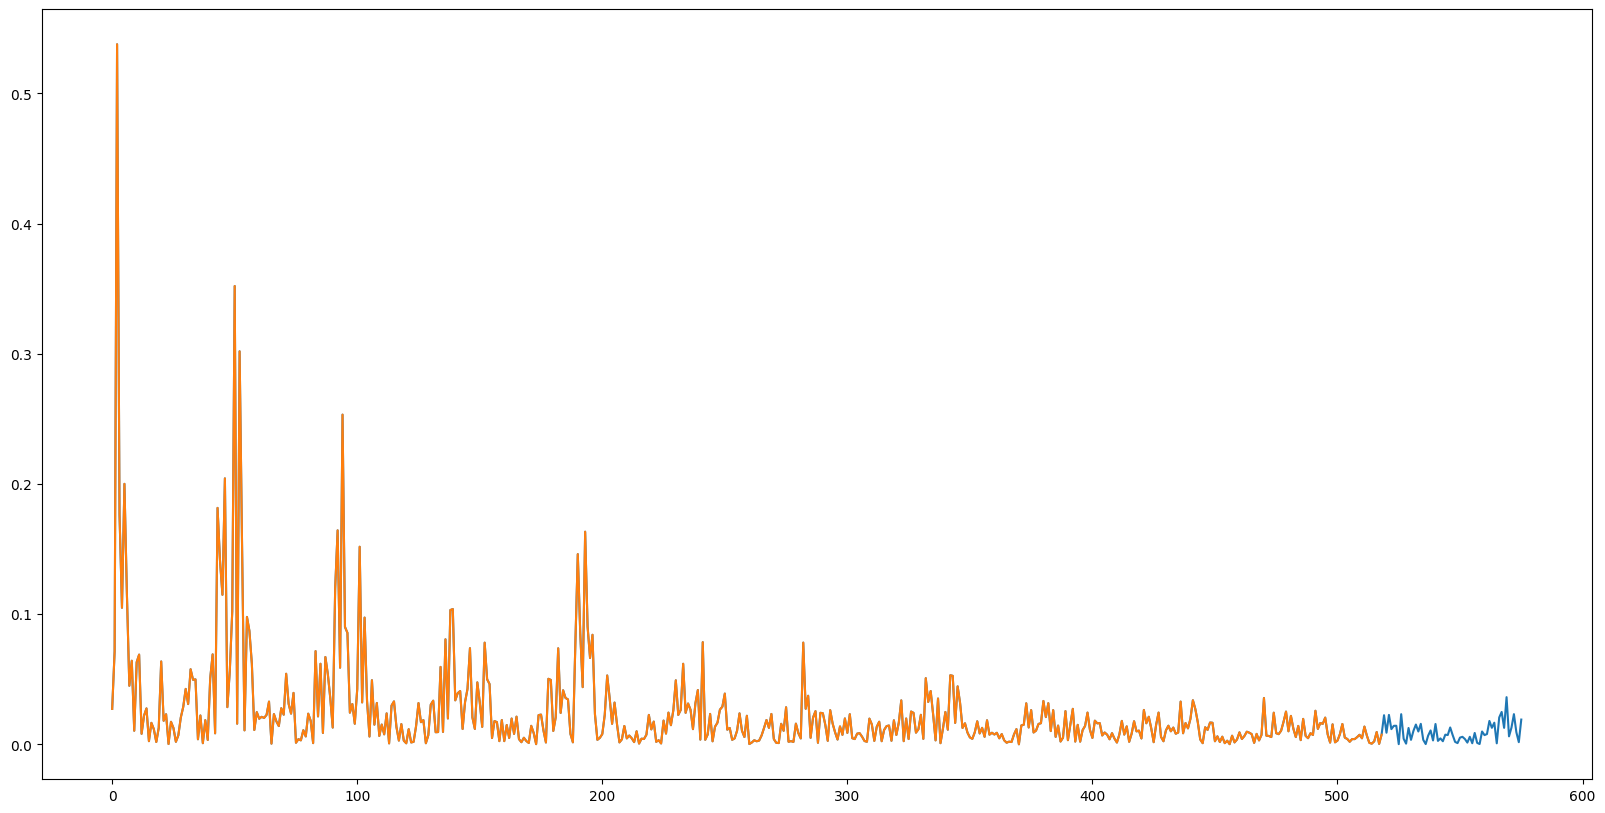

torch.Size([1, 468, 768])
torch.Size([1, 576, 768])


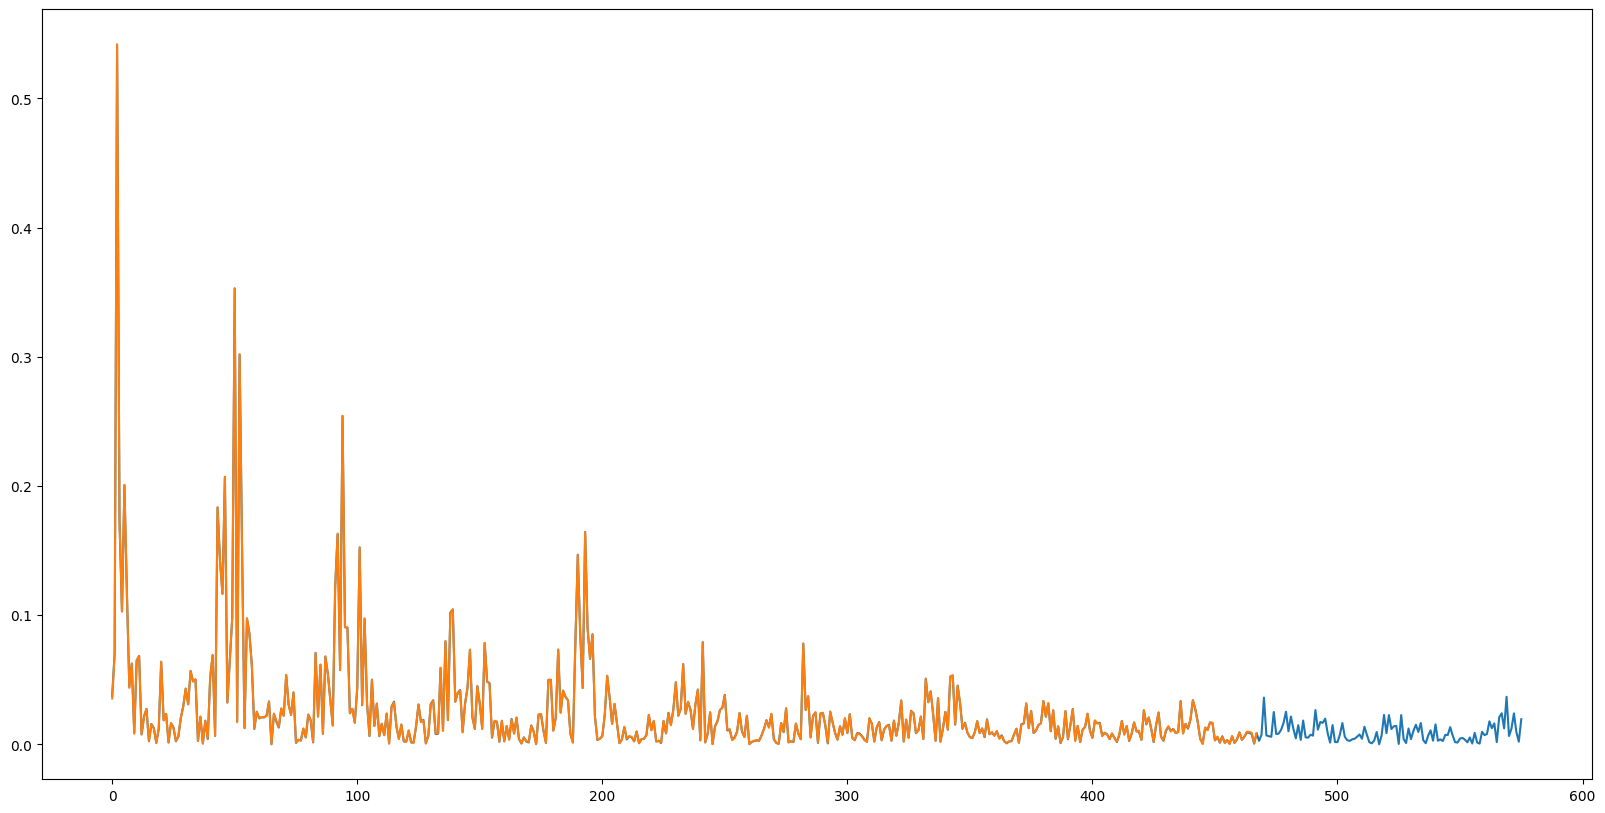

torch.Size([1, 422, 768])
torch.Size([1, 576, 768])


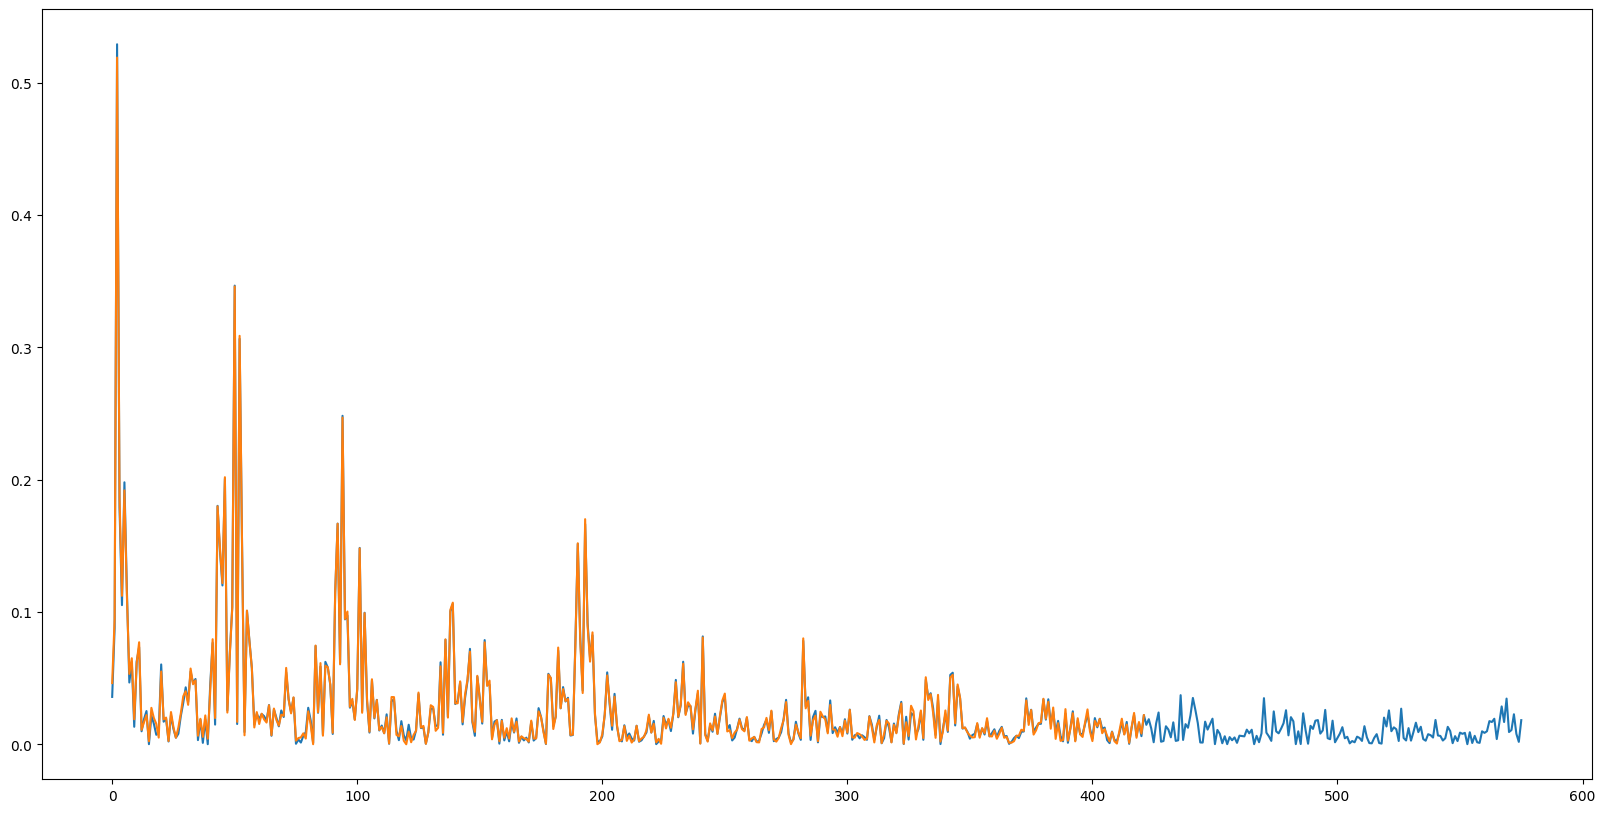

In [17]:
from tqdm.auto import tqdm
import numpy as np
for batch in tqdm(test_loader):
    break
with torch.no_grad():
    # print(batch['pixel_values'].shape)
    _,_, hidden_states,x_dct,_ = model.get_vision_features(pixel_values=batch['pixel_values'].to(device), use_compressed_hidden_state=False,return_all_hidden_state=True)
    _,_, filtered_hidden_states,x_dct_filtered,_ = model.get_vision_features(pixel_values=batch['pixel_values'].to(device), use_compressed_hidden_state=True, return_all_hidden_state=True)
    for i in range(len(filtered_hidden_states)):
        
        # filtered_hidden_state = filtered_hidden_states[i].permute(1,0,2)
        # hidden_state = hidden_states[i].permute(1,0,2)
        # x_dct_filtered = dct(filtered_hidden_state.transpose(0,2), norm='ortho').transpose(0,2)
        # x_dct = dct(hidden_state.transpose(0,2), norm='ortho').transpose(0,2)[:x_dct_filtered.shape[0],:, :]
        # x_dct_filtered =x_dct_filtered.permute(1,0,2)
        # x_dct = x_dct.permute(1,0,2)
        # threshold = 0.05 
        pred = x_dct_filtered[i]
        # pred = upsample(pred.permute(0,2,1)).permute(0,2,1)
        target = x_dct[i]
        print(pred.shape)
        print(hidden_states[i].shape)
        # pred_amplitude = torch.abs(x_dct_filtered[i])
      
        # x_dct_filtered_mean =pred.mean(0).mean(1)
        # x_dct_mean = target.mean(0).mean(1)
        # x_dct_filtered_mean =torch.abs(pred.mean(0).mean(1))
        # x_dct_mean = torch.abs(target.mean(0).mean(1))
        x_dct_filtered_mean =pred.mean(0)
        x_dct_mean = target.mean(0)
        
        x_dct_filtered_std =torch.abs(pred.mean(0).mean(1))
        x_dct_mean_std = torch.abs(target.mean(0).mean(1))
        # threshold =torch.quantile(x_dct_mean, 0.95, dim=-1, keepdim=True) 

        # indices = torch.where(x_dct_mean > threshold)
        # last_index = indices[0][-1].item() if indices[0].numel() > 0 else -1
        # print(threshold)
        # print(last_index)

        plt.figure(figsize=(20, 10))
        plt.plot(x_dct_mean_std.cpu().detach().numpy())
        plt.plot(x_dct_filtered_std.cpu().detach().numpy())
        # plt.imshow(x_dct_filtered_mean.cpu().detach().numpy())
        # plt.imshow(x_dct_mean.cpu().detach().numpy())
        # plt.plot(x_dct_mean)
        # plt.plot(x_dct_filtered_mean)
        plt.show()
      

# plot_hidden_states(hidden_states, filtered=True)

In [8]:
# from lavis.models import load_model_and_preprocess
# from model.modules.compressed_models import CompressedLAVISBLIP2, CompressedLAVISBLIP


# model, vis_processors, txt_processors = load_model_and_preprocess("blip_retrieval", "flickr", is_eval=False)
# train_loader, val_loader, test_loader = get_loaders(
#     20, 
#     dataset,
#     vis_processor=vis_processors['eval'],
#     txt_processor=txt_processors['eval'],
#     tokenizer=model.tokenizer,
# )
# device = torch.device('cpu')
# # model = CompressedLAVISBLIP2(model, compress_method='std')


In [9]:
for batch in train_loader:
    print(batch['pixel_values'].shape)
    break

torch.Size([40, 3, 224, 224])


In [10]:
# vit_embeds, pooled_output, all_hidden_states, _ = model.get_vision_features(batch['pixel_values'], return_all_hidden_state=True)

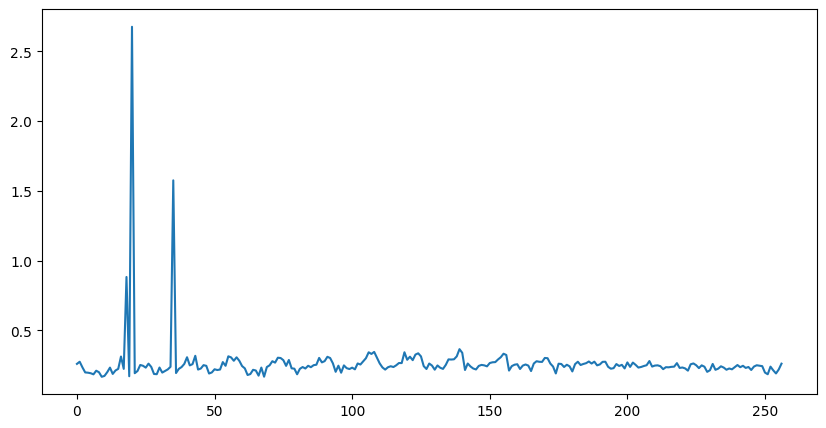

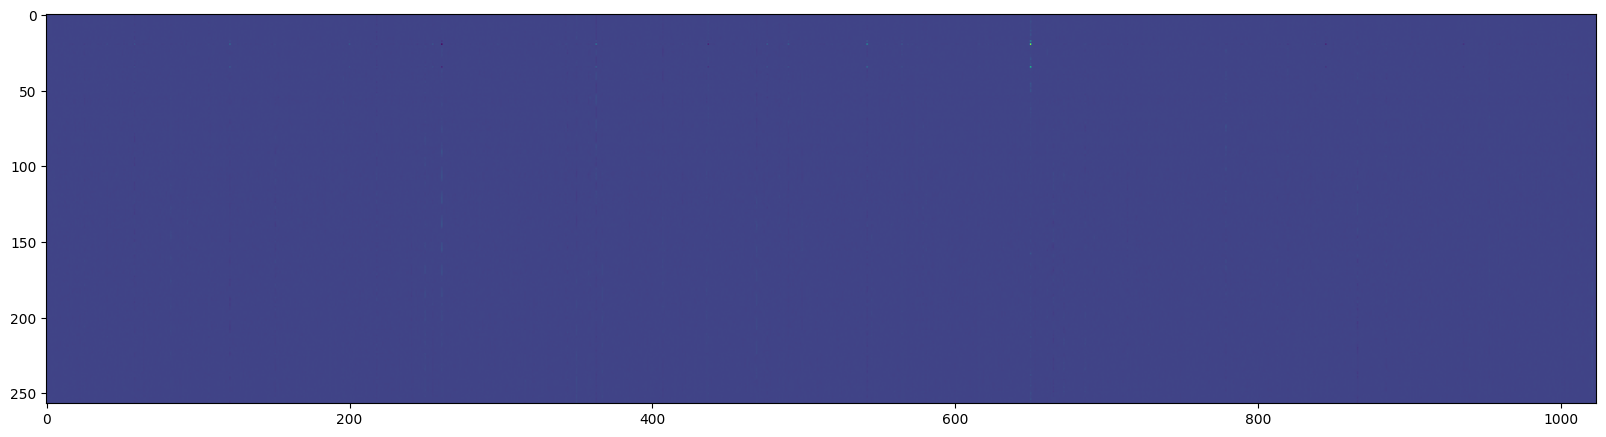

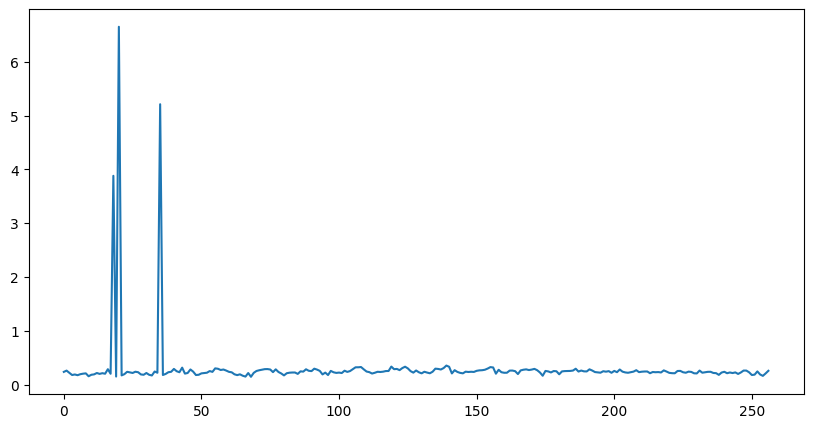

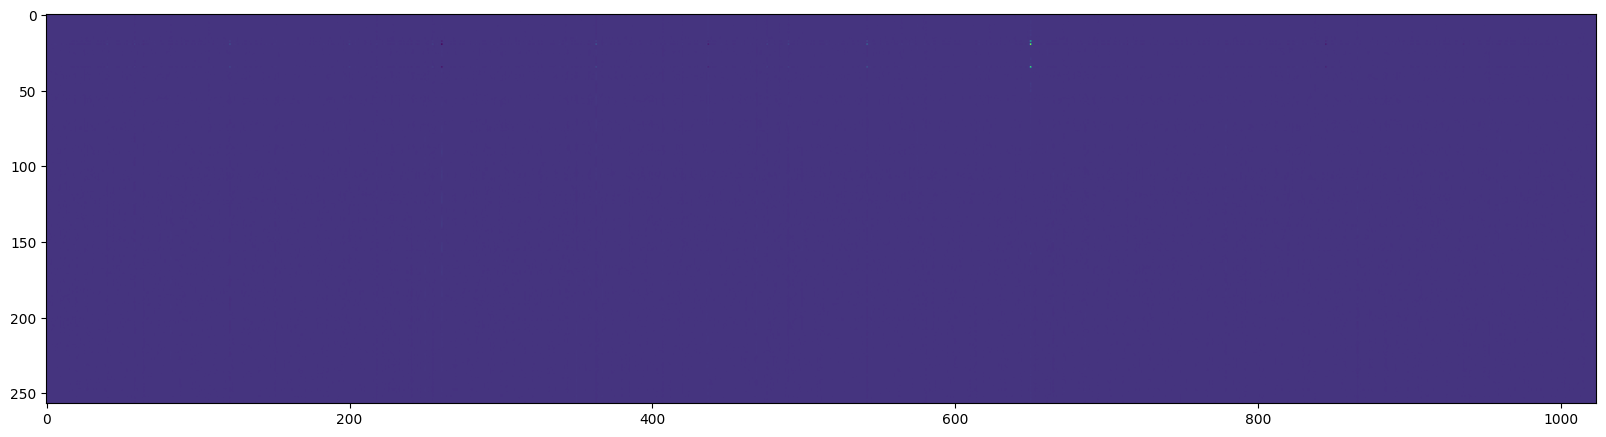

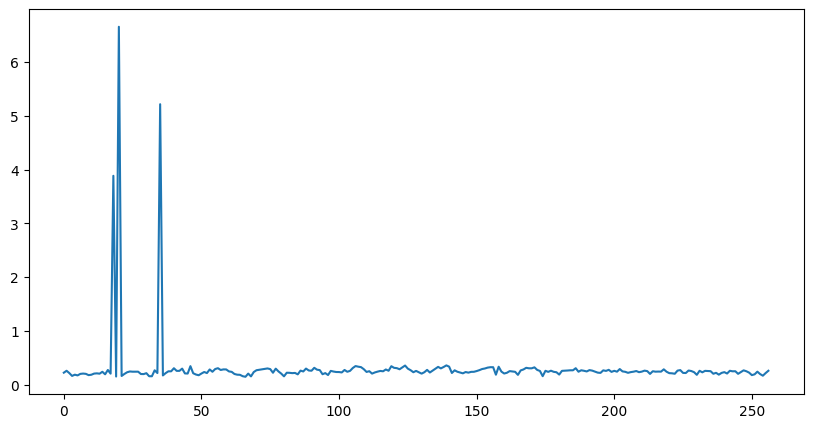

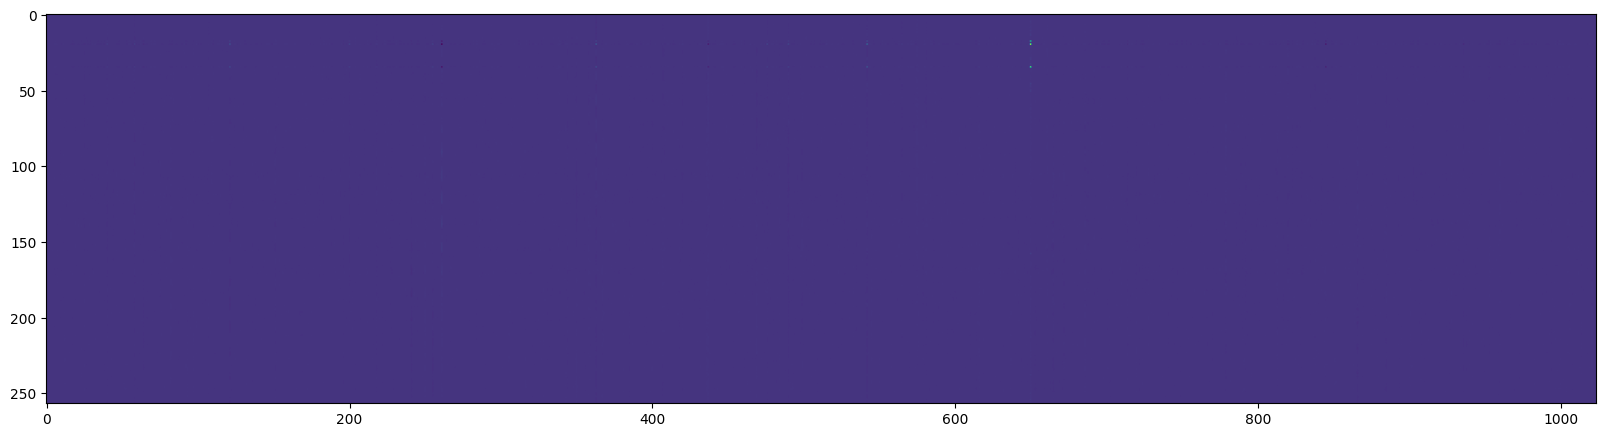

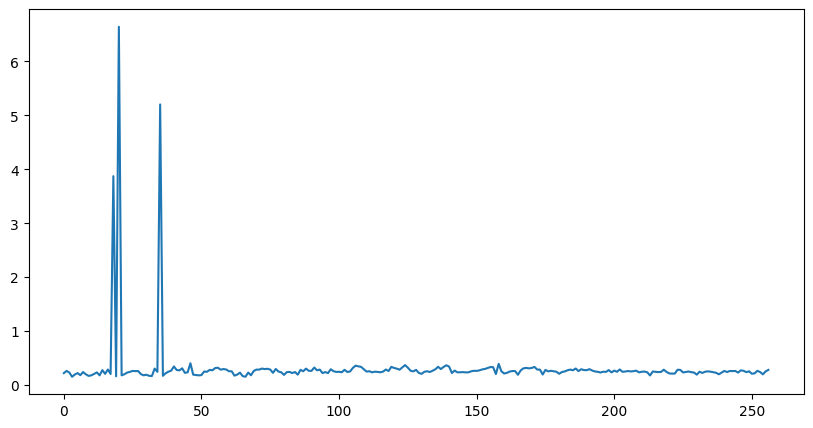

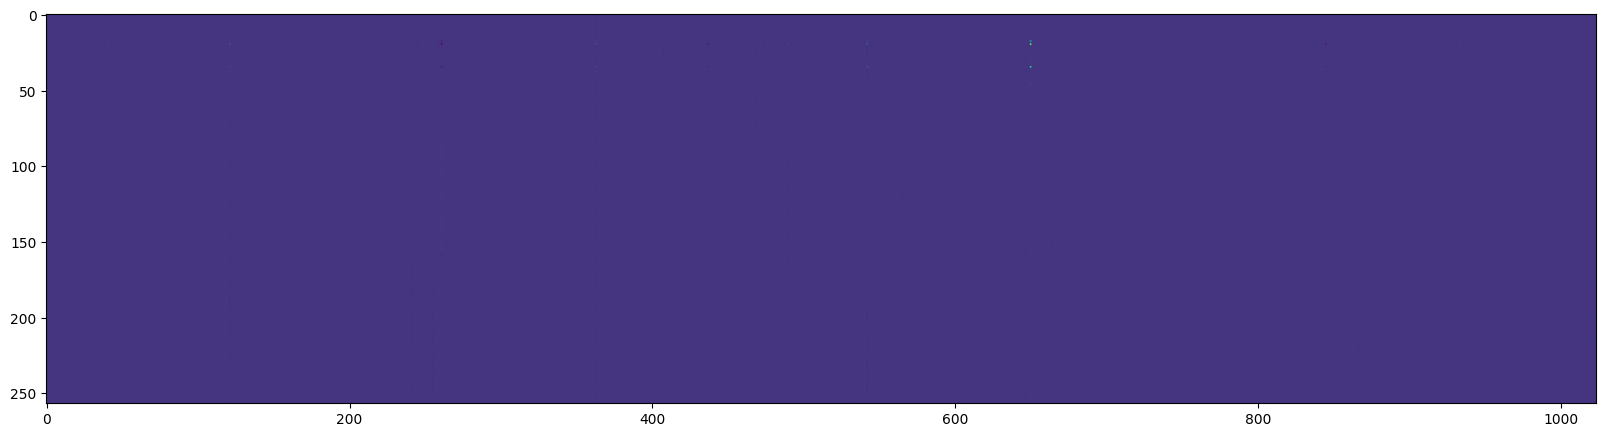

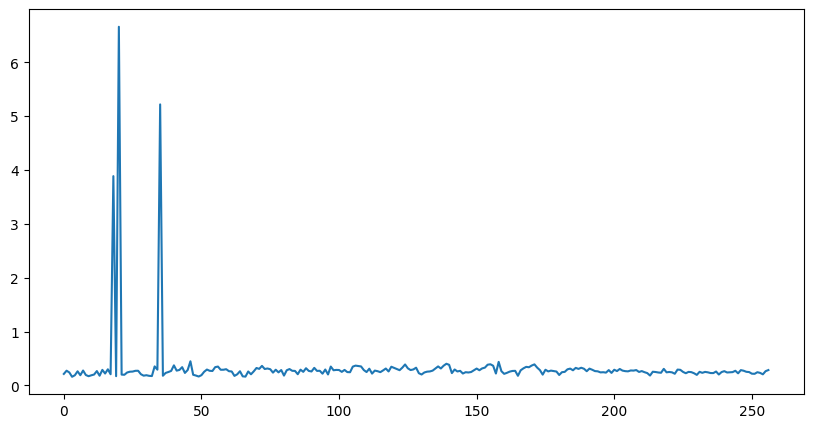

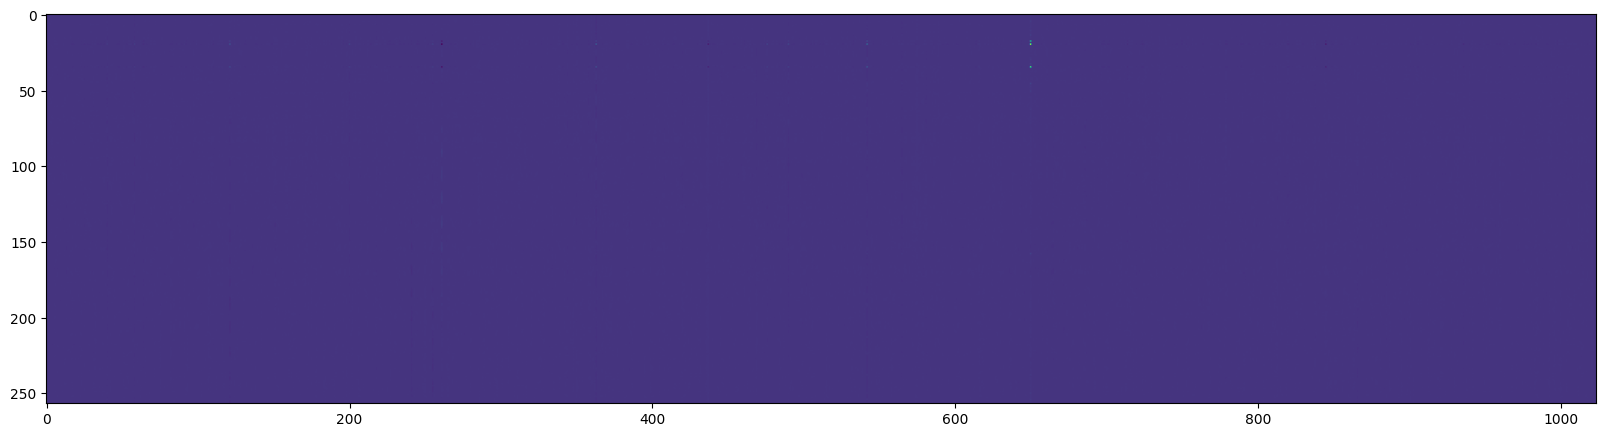

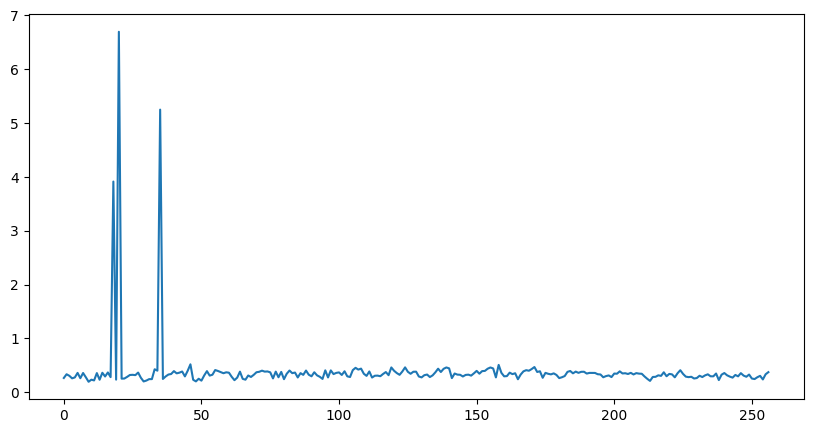

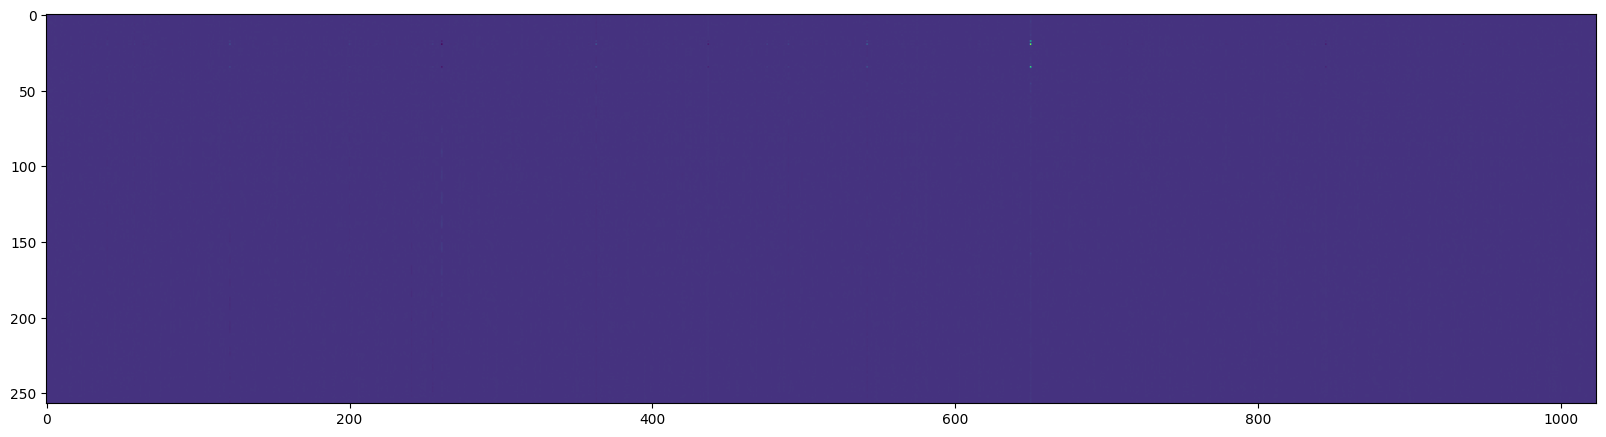

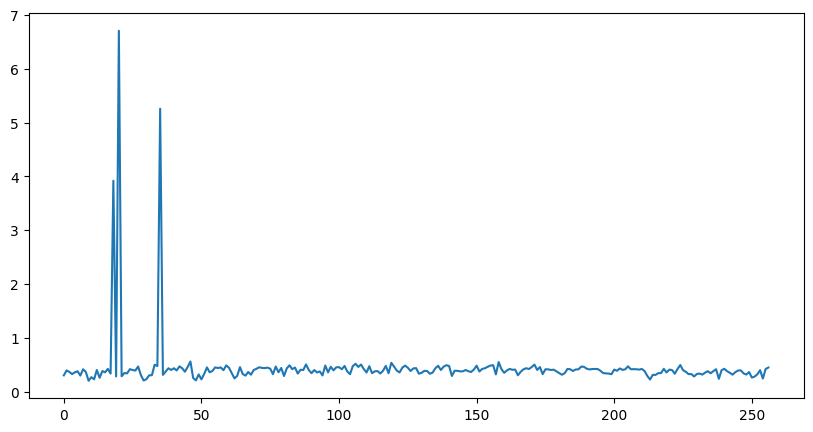

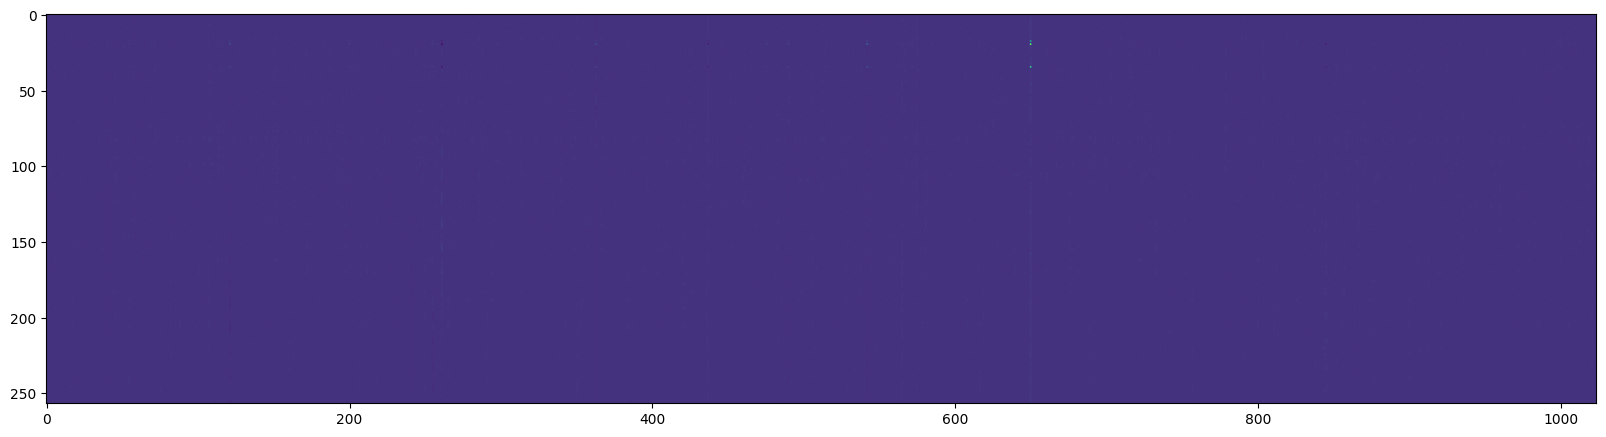

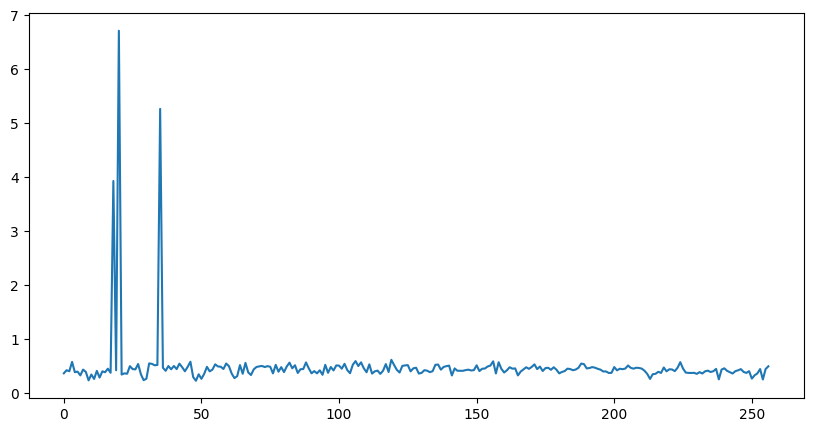

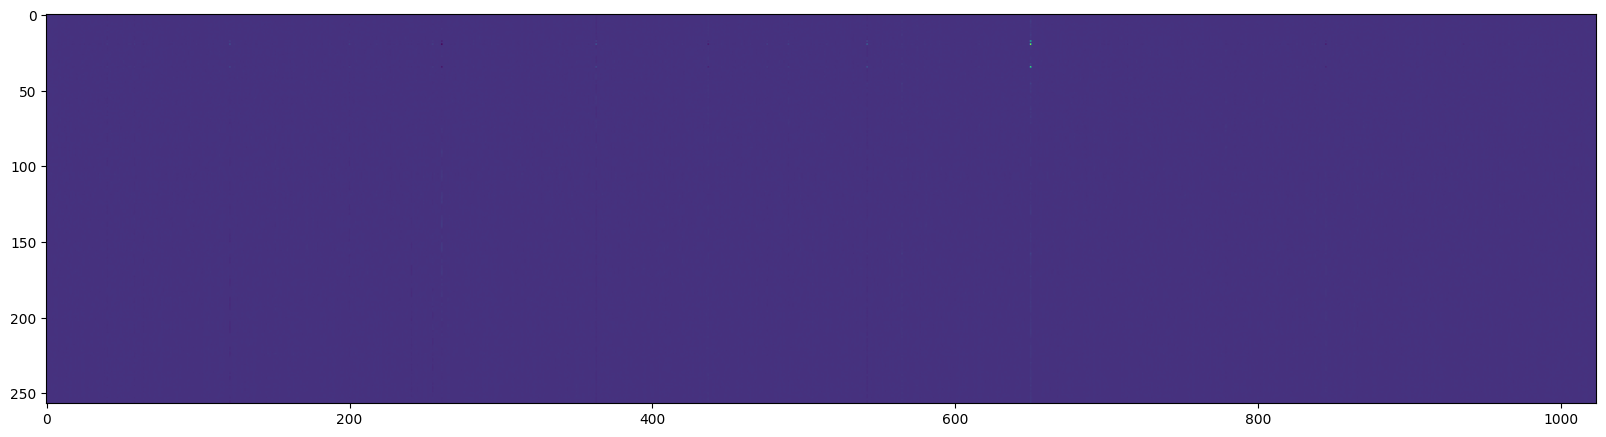

In [11]:
for i, state in enumerate(hidden_states):
    # if i  len(all_hidden_states):
    std = state.mean(0).std(1)
    plt.figure(figsize=(10, 5))
    plt.plot(std)
    plt.figure(figsize=(20, 10))
    plt.imshow(state.mean(0))
# plt.plot(pooled_output.detach().mean(0).std(1).numpy())
# plt.plot(torch.abs(pooled_output.mean(0).std(1)))

In [12]:
model.visual_encoder

AttributeError: 'CompressedHFCLIP' object has no attribute 'visual_encoder'